# [Kaggle] PetFinder.my Adoption Prediction - EDA

- 목표: 말레이시아의 유기동물 보호소에서 각 동물들이 얼마나 빨리 입양될지 속도를 예측
- 평가지표: Quadratic weighted kappa
- 데이터: (train: 14,993)

### Loading packages

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from collections import OrderedDict
import warnings
from matplotlib import pylab as plt
from sklearn import preprocessing
from IPython.display import Image
warnings.filterwarnings('ignore')

In [2]:
from kaggle import KaggleApi
api = KaggleApi()
api.authenticate()

## 데이터 피처

- AdoptionSpeed - Categorical speed of adoption. Lower is faster. This is the value to predict. See below section for more info.
- Type - Type of animal (1 = Dog, 2 = Cat)
- Name - Name of pet (Empty if not named)
- Age - Age of pet when listed, in months
- Breed1 - Primary breed of pet (Refer to BreedLabels dictionary)
- Breed2 - Secondary breed of pet, if pet is of mixed breed (Refer to BreedLabels dictionary)
- Gender - Gender of pet (1 = Male, 2 = Female, 3 = Mixed, if profile represents group of pets)
- Color1 - Color 1 of pet (Refer to ColorLabels dictionary)
- Color2 - Color 2 of pet (Refer to ColorLabels dictionary)
- Color3 - Color 3 of pet (Refer to ColorLabels dictionary)
- MaturitySize - Size at maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)
- FurLength - Fur length (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)
- Vaccinated - Pet has been vaccinated (1 = Yes, 2 = No, 3 = Not Sure)
- Dewormed - Pet has been dewormed (1 = Yes, 2 = No, 3 = Not Sure)
- Sterilized - Pet has been spayed / neutered (1 = Yes, 2 = No, 3 = Not Sure)
- Health - Health Condition (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)
- Quantity - Number of pets represented in profile
- Fee - Adoption fee (0 = Free)
- State - State location in Malaysia (Refer to StateLabels dictionary)
- RescuerID - Unique hash ID of rescuer
- VideoAmt - Total uploaded videos for this pet
- PhotoAmt - Total uploaded photos for this pet
- Description - Profile write-up for this pet. The primary language used is English, with some in Malay or Chinese.

이번 대회의 목적은 각각의 펫 정보를 바탕으로 각각의 펫들이 얼마나 빨리 입양 될지를 에측해야되는 문제다.

### 평가지표 : Quadratic Weighted Kappa

- 예측한 rating 값(0 ~ 4)과 실제 rating 값(정답)의 오차를 측정하기 위해 쓰임
- 예측 값과 실제 값이 독립적(랜덤한 값)이라면 0에 가까운 값이 나오며, 둘의 값이 비슷할 수록 1에 가깝게 됨
- 즉, 예측값이 답에 가까울수록 quadratic weighted kappa는 1에 가까운 값이 나옴

#### (참고) Quadratic weighted kappa 정의




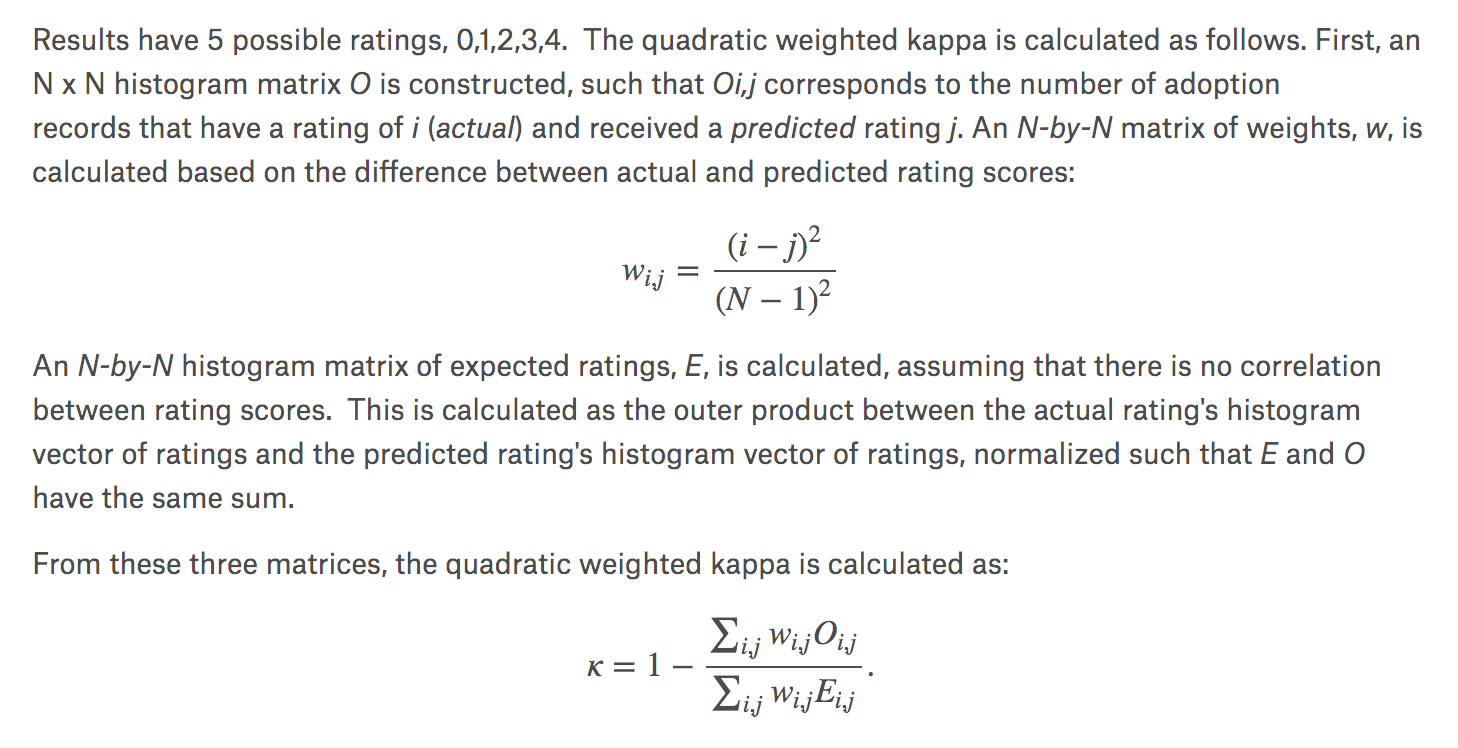

In [5]:
Image("img/quadratic_weight_kappa.png")

### Loading Data

In [10]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
breed_labels = pd.read_csv('breed_labels.csv')
color_labels = pd.read_csv('color_labels.csv')
state_labels = pd.read_csv('state_labels.csv')

## 1. 데이터 Overview

### Train 데이터셋

In [11]:
train.head(5)

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,...,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0
2,1,Brisco,1,307,0,1,2,7,0,2,...,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3
3,1,Miko,4,307,0,2,1,2,0,2,...,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2
4,1,Hunter,1,307,0,1,1,0,0,2,...,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2


In [17]:
train.columns

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed'],
      dtype='object')

In [15]:
train.shape

(14993, 24)

데이터에서 다음을 관찰할 수 있다.

- 총 14,993의 관측치와 23개의 독립변수(AdoptionSpeed는 종속변수이므로 제외)로 구성
- Breed1, Breed2 등에서 보여지듯이 다른 데이터 테이블에 대한 레퍼런스 값을 갖고 있으므로 추후에 관련 데이터를 join할 예정

- AdoptionSpeed에 직접적으로 영향을 줄 것 같은 변수 vs 간접적으로 줄 것 같은 변수 vs 연관 없을 것 같은 변수로 직관적인 구분 가능
    - 직접적으로 영향을 미칠 것 같은 predictors: Age, Gender, maturitySize, Vaccinated, Dewormed, Sterilized, Health, Fee
    - 간접적으로 영향을 미칠 것 같은 predictors: Breed1, Breed2, Color1, Color2, Color3, FurLength, State, VideoAmt, Description, RescuerID, PhotoAmt
    - 영향을 미치지 않을 것 같은 predictors: PetID, Name

### 보조 데이터셋

1) breed_labels.csv

In [498]:
breed_labels.head(3)

,BreedID,Type,BreedName
0,1,1,Affenpinscher
1,2,1,Afghan Hound
2,3,1,Airedale Terrier


In [26]:
# Type별 (1: doge, 2: cat) unique BreedName 개수
breed_labels.groupby('Type')['BreedName'].nunique()

Type
1    241
2     66
Name: BreedName, dtype: int64

2) color_lables.csv

In [499]:
color_labels.head(3)

,ColorID,ColorName
0,1,Black
1,2,Brown
2,3,Golden


In [28]:
color_labels.ColorName.nunique()

7

3) state_labels.csv

In [500]:
state_labels.head(3)

,StateID,StateName
0,41336,Johor
1,41325,Kedah
2,41367,Kelantan


In [29]:
state_labels.StateName.nunique()

15

- breed labels: dog - 241가지, cat - 66가지로, dog의 종류가 고양이에 비해 약 4배 많음
- color labels: 7 가지
- state labels: 15 가지
- 각각의 테이블에 ID가 있으니 ID 값을 바탕으로 train 데이터셋과 join

#### 추후에 진행할 데이터 전처리와 피처 엔지니어링을 위해 train, test 데이터셋을 합쳐서 하나의 'data' 데이터셋으로 만듦

In [41]:
# 나중에 다시 train, test로 쪼개기 쉽도록 is_train으로 원본 데이터 종류 구분
train = train.assign(is_train = True)
test = test.assign(is_train = False)

# test 데이터셋의 경우 AdoptionSpeed이 비어있을테니, 일단 -1로 채움
test = test.assign(AdoptionSpeed = -1)

# train과 test 데이터를 합침
data = pd.concat([train, test], sort=True)

합친 데이터에 각 보조 데이터를 join 하자.

1) color labels 

In [42]:
data_color1 = data.merge(color_labels, how='left', left_on='Color1', right_on='ColorID', left_index=False, right_index=False).drop(columns='ColorID')
data_color2 = data_color1.merge(color_labels, how='left', left_on='Color2', right_on='ColorID').drop(columns='ColorID')
data_color3 = data_color2.merge(color_labels, how='left', left_on='Color3', right_on='ColorID').drop(columns='ColorID')

In [43]:
data = data_color3

2) breed labels

In [44]:
data_breed1 = data.merge(breed_labels, how='left', left_on=['Breed1', 'Type'], right_on=['BreedID', 'Type']).drop(columns='BreedID')
data_breed2 = data_breed1.merge(breed_labels, how='left', left_on=['Breed2', 'Type'], right_on=['BreedID', 'Type']).drop(columns='BreedID')

In [45]:
data = data_breed2

3) state labels

In [46]:
data_state = data.merge(state_labels, how='left', left_on='State', right_on='StateID').drop(columns='StateID')

In [47]:
data = data_state

기존에 있었던 컬럼은 삭제

In [48]:
data.drop(columns=['Breed1', 'Breed2', 'Color1', 'Color2', 'Color3', 'State'], inplace=True)

#### EDA를 하기 위해 각 범주형 변수들 값을 숫자가 아닌 명시적인 값으로 매핑

In [49]:
data = data.replace({'Type': {1: 'Dog', 2: 'Cat'},
              'Gender': {1: 'Male', 2: 'Female', 3: 'Mixed'},
              'Vaccinated': {1: 'Yes', 2: 'No', 3: 'Not Sure'},
              'Dewormed': {1: 'Yes', 2: 'No', 3: 'Not Sure'},
              'Sterilized': {1: 'Yes', 2: 'No', 3: 'Not Sure'}

             })

In [50]:
# data = data.replace({
#     'MaturitySize': {1: 'Small', 2: 'Medium', 3: 'Large', 4: 'Extra Large', 0:'Not Specified'},
#     'FurLength': {1:'Short', 2: 'Medium', 3: 'Long', 0: 'Not Specified'},
#     'Health': {1: 'Healthy', 2: 'Minor Injury', 3: 'Serious Injury', 0: 'Not Specified'}
# })

순서형 변수인 MaturitySize, FurLength, Health의 경우 순서형 데이터의 특성을 사리기 위해 숫자로 유지하자

In [52]:
data.columns

Index(['AdoptionSpeed', 'Age', 'Description', 'Dewormed', 'Fee', 'FurLength',
       'Gender', 'Health', 'MaturitySize', 'Name', 'PetID', 'PhotoAmt',
       'Quantity', 'RescuerID', 'Sterilized', 'Type', 'Vaccinated', 'VideoAmt',
       'is_train', 'ColorName_x', 'ColorName_y', 'ColorName', 'BreedName_x',
       'BreedName_y', 'StateName'],
      dtype='object')

In [66]:
# 컬럼명 정렬
mapping = {
    'ColorName_x': 'ColorName1',
    'ColorName_y': 'ColorName2',
    'ColorName': 'ColorName3',
    'BreedName_x': 'BreedName1',
    'BreedName_y': 'BreedName2'
}
data.columns = [mapping[colname] if colname in mapping.keys() else colname for colname in data.columns]

In [147]:
data.head()

,AdoptionSpeed,Age,Description,Dewormed,Fee,FurLength,Gender,Health,MaturitySize,Name,...,Type,Vaccinated,VideoAmt,is_train,ColorName1,ColorName2,ColorName3,BreedName1,BreedName2,StateName
0,2,3,Nibble is a 3+ month old ball of cuteness. He ...,No,100,1,Male,1,1,Nibble,...,Cat,No,0,True,Black,White,NaN,Tabby,NaN,Selangor
1,0,1,I just found it alone yesterday near my apartm...,Not Sure,0,2,Male,1,2,No Name Yet,...,Cat,Not Sure,0,True,Black,Brown,NaN,Domestic Medium Hair,NaN,Kuala Lumpur
2,3,1,Their pregnant mother was dumped by her irresp...,Yes,0,2,Male,1,2,Brisco,...,Dog,Yes,0,True,Brown,White,NaN,Mixed Breed,NaN,Selangor
3,2,4,"Good guard dog, very alert, active, obedience ...",Yes,150,1,Female,1,2,Miko,...,Dog,Yes,0,True,Black,Brown,NaN,Mixed Breed,NaN,Kuala Lumpur
4,2,1,This handsome yet cute boy is up for adoption....,No,0,1,Male,1,2,Hunter,...,Dog,No,0,True,Black,NaN,NaN,Mixed Breed,NaN,Selangor


### merged 데이터셋 저장

In [98]:
# merged_data 저장
data.to_parquet('merged_data', compression='GZIP')

## Visualization

- 모든 변수에 대해 시각화 하는 것은 초기 EDA 단계에서는 비생산적으로 보임 
- 따라서 직관적으로 AdoptionSpeed에 직접적으로 영향을 미칠 것 같은 변수들을 우선 추려서 큰 그림 파악 
- 추후에 2차 EDA를 할 때 간접적인 변수들 보기 

In [4]:
data = pd.read_parquet('merged_data')

In [5]:
data.columns

Index(['AdoptionSpeed', 'Age', 'Description', 'Dewormed', 'Fee', 'FurLength',
       'Gender', 'Health', 'MaturitySize', 'Name', 'PetID', 'PhotoAmt',
       'Quantity', 'RescuerID', 'Sterilized', 'Type', 'Vaccinated', 'VideoAmt',
       'is_train', 'ColorName1', 'ColorName2', 'ColorName3', 'BreedName1',
       'BreedName2', 'StateName'],
      dtype='object')

In [6]:
# 직접적인, 간접적인 변수로 나눔
explicit_predictors = ['Type','Age', 'Gender', 'MaturitySize', 'Vaccinated', 'Dewormed', 'Sterilized', 'Health', 'Fee']
implicit_predictors1 = ['BreedName1', 'BreedName2', 'ColorName1', 'ColorName2', 'ColorName3', 'FurLength', 'StateName']
implicit_predictors2 = ['VideoAmt', 'Description', 'PhotoAmt']

In [7]:
df = data[explicit_predictors + ['AdoptionSpeed', 'is_train']]

In [8]:
df_implicit = data[implicit_predictors1 + ['AdoptionSpeed', 'is_train', 'Type']]

In [9]:
# 시각화의 편의를 위해 is_train 컬럼에 대한 데이터 삭제
df = df.loc[df.is_train].drop(columns=['is_train'])
df_implicit = df_implicit.loc[df_implicit.is_train].drop(columns=['is_train'])

In [10]:
df.head(3)

,Type,Age,Gender,MaturitySize,Vaccinated,Dewormed,Sterilized,Health,Fee,AdoptionSpeed
index,,,,,,,,,,
0,Cat,3,Male,1,No,No,No,1,100,2
1,Cat,1,Male,2,Not Sure,Not Sure,Not Sure,1,0,0
2,Dog,1,Male,2,Yes,Yes,No,1,0,3


우선, 간단한 시각화로 데이터 특성을 파악하자.

### 타겟 변수: AdoptionSpeed

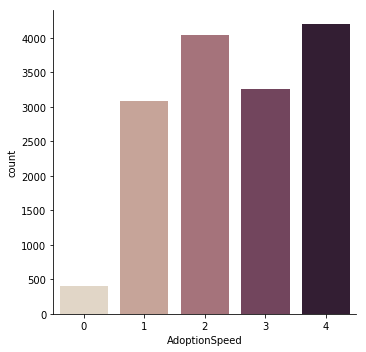

In [13]:
sns.catplot(x="AdoptionSpeed", kind="count", palette="ch:.25", data=df);

- AdoptionSpeed가 클수록 입양되는데 시간이 오래 걸린다는 의미
- 0일 때를 제외하고는 데이터 수에 큰 차이 없음
- 4 (가장 오래걸림)이 상대적으로 많음. 애초에 입양 센터에 들어오는 펫들은 유기되거나 장애가 있을 수 있는 만큼 입양을 선호 대상이 아닐 수 있어서 입양되는데 시간이 걸리는 것일 수 있음 
- 0이 적은 이유는 분양 센터에 들어오고 난후 사이트에 리스팅 되는데까지 시간이 걸려서 일 수도 있고, 또는 입양 센터에 들어온지 오래된 동물들을 먼저 노출하는 정책이 있을 수 있음. (웹사이트를 직접 써보면서 파악할 필요 있음) 

### 직접적인 영향 주는 변수들 간의 관계

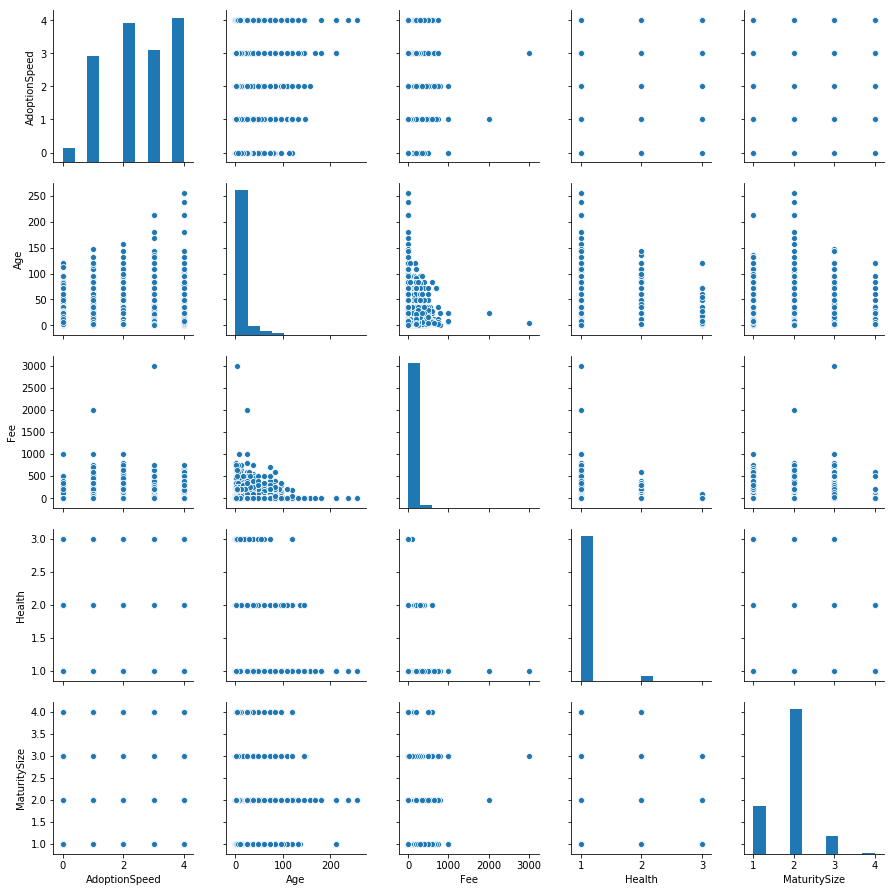

In [14]:
df_numeric = df[['AdoptionSpeed', 'Age', 'Fee', 'Health', 'MaturitySize']]
sns.pairplot(df_numeric);

- Age, Fee, Health의 경우 강한 Skewness가 있어서 log scaling으로 skewness를 완화할 필요가 있어보임
    - Age: 나이가 어린 펫의 비율이 상당히 높으며 100개월(약 8년) 이상된 펫은 거의 없음
    - Fee: 대부분 0(무료)이며 소수지만 Fee가 있는 경우도 있음. Fee를 기준으로 각 피쳐들 간의 분포를 봤을때 2개 정도의 outlier가 관측됨. 추가 분석 필요.
    - Health: 대부분 건강함. 간혹 건강이 안좋은 경우도 있음.

#### 각 요소별 AdoptionSpeed와의 관계

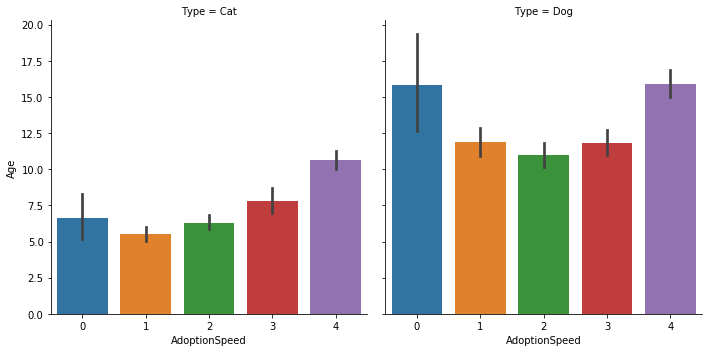

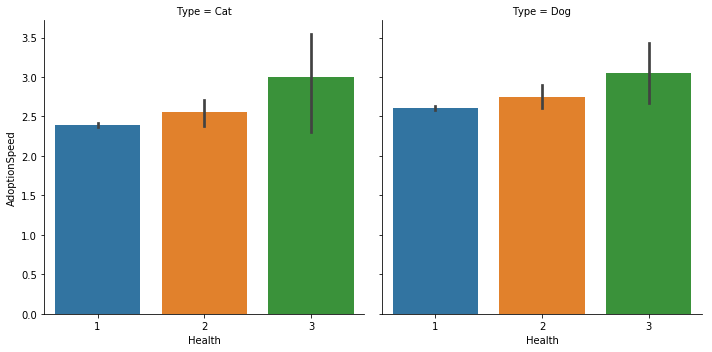

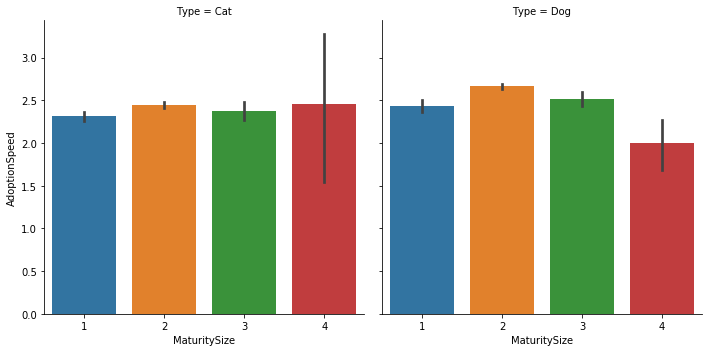

In [28]:
sns.catplot(x='AdoptionSpeed', y='Age', kind='bar', col='Type', data=df)
sns.catplot(x='Health', y='AdoptionSpeed', kind='bar', col='Type', data=df)
sns.catplot(x='MaturitySize', y='AdoptionSpeed', kind='bar', col='Type', data=df);


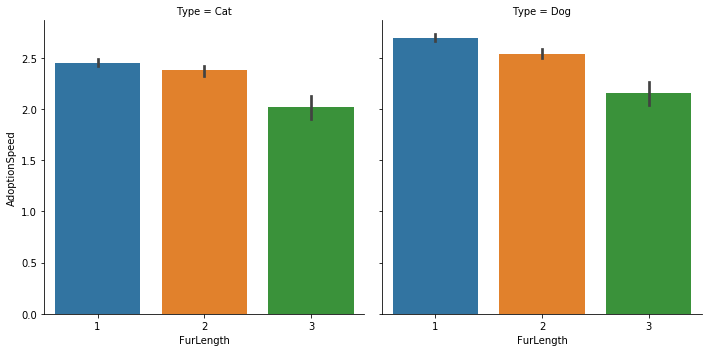

In [27]:
sns.catplot(x='FurLength', y='AdoptionSpeed', kind='bar', col='Type', data=df_implicit);

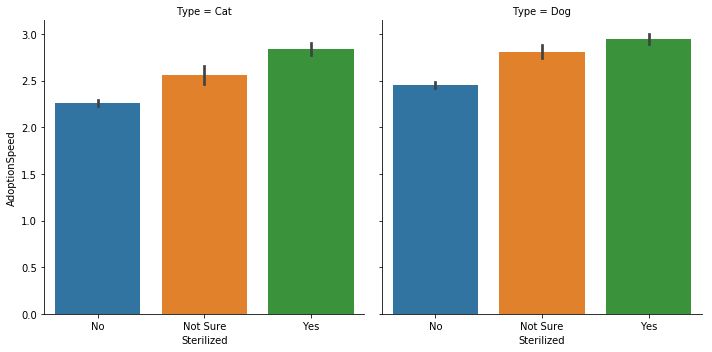

In [15]:
sns.catplot(x='Sterilized', y='AdoptionSpeed', kind='bar', col='Type', data=df);

- Cat이든 Dog이든 좀 더 어린 펫을 선호하는 경향 있음
- Cat이든 Dog이든 건강한 펫을 선호하는 경향 있음
- Cat이든 Dog이든 펫의 털이 긴 편을 선호하는 경향 있음
- Cat이든 Dog이든 Sterilized를 안한 경우를 선호하는 경향 있음
- Cat의 경우 사이즈가 입양 속도에 큰 영향을 주지 않는 것으로 보이며, Dog의 경우 큰 사이즈를 선호하는 경향 보임

직접적으로 영향을 미친다고 생각하지 않았던 StateName를 좀더 보자.

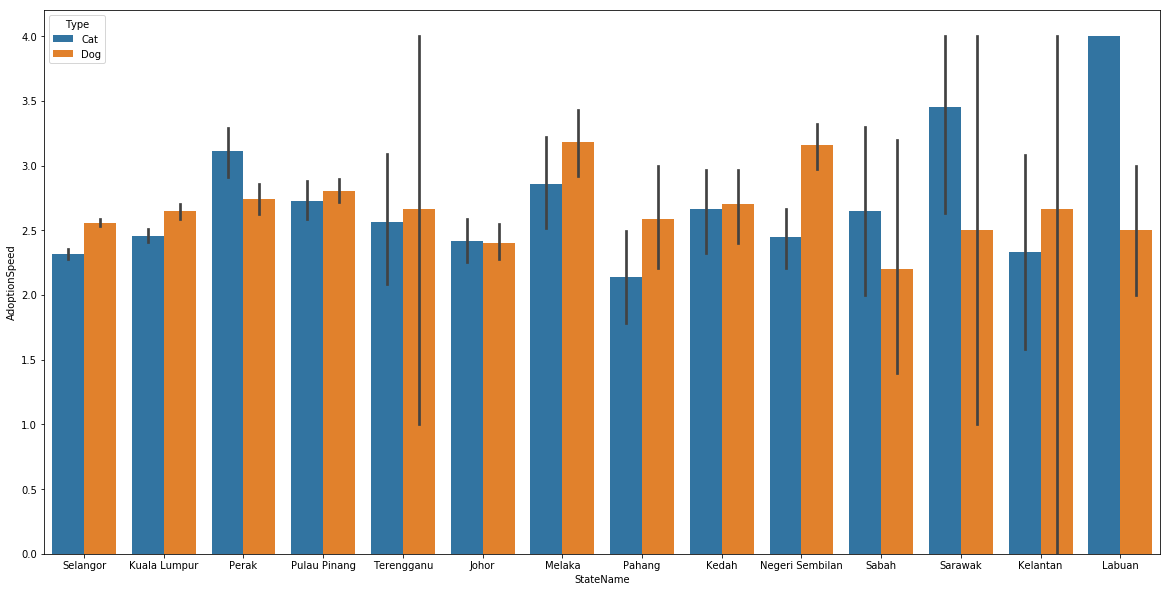

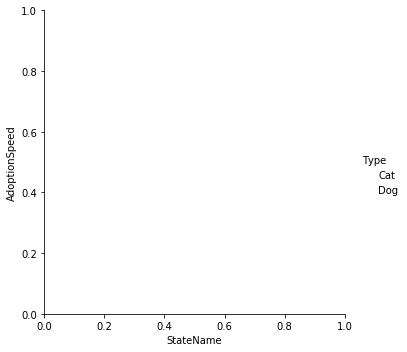

In [36]:
_, ax = plt.subplots(figsize=(20, 10))
sns.catplot(ax=ax, x='StateName', y='AdoptionSpeed', kind='bar', hue='Type', data=df_implicit)


- 생각과 다르게 State별 차이가 확연히 드러남
    - Dog를 선호하는 State: Perak, Sabah, Sarawak, Labuan (Cat을 큰 비선호하는 경향 보임)
    - Cat을 선호하는 State: 나머지 10개
    - 선호 현상이 크게 차이나는 State: Perak(dog), Melaka (cat), Pahang (cat), Negeri Sembilan (cat), Sabah (dog), Sarawak (dog), Labuan (dog)
    - 전반적으로 Cat을 선호하는 State가 월등히 많음
    
- 추후에 Hierarchical bayesian ordinal logistic 알고리즘을 쓸때 가장 상위 Hierarchy에 놓으면 좋을 것으로 보임

### Fee에 대해 자세히 살펴보기

In [16]:
df.Fee.describe(percentiles=np.linspace(0, 1, 11))

count    14993.000000
mean        21.259988
std         78.414548
min          0.000000
0%           0.000000
10%          0.000000
20%          0.000000
30.0%        0.000000
40%          0.000000
50%          0.000000
60.0%        0.000000
70%          0.000000
80%          0.000000
90%         50.000000
100%      3000.000000
max       3000.000000
Name: Fee, dtype: float64

- 80%의 펫은 입양비가 무료
- 상위 10%~20%의 펫의 평균 입양비는 50
- 상위 10%의 펫의 평균 입양비는 3000

#### Fee 무료와 유료간의 입양속도에 차이가 있을까?

In [17]:
df = df.assign(Fee_free = df.Fee == 0)

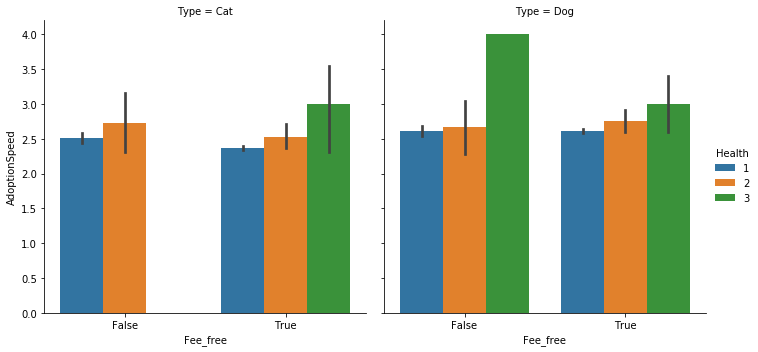

In [18]:
sns.catplot(x='Fee_free', y='AdoptionSpeed', kind='bar', hue='Health', col='Type', data=df);

- Cat의 경우
    - 무료의 경우 (Fee_free = True): 일반적인 패턴을 보임 (건강이 안 좋아질수록 입양 속도가 오래 걸림)
    - 유료의 경우 (Fee_free = False): 건강이 안좋은 경우 유료로 안 받는것으로 보임
        
- Dog의 경우
    - 무료의 경우: 일반적인 패턴을 보임 (건강이 안좋아 질수록 입양 속도가 오래 걸림).
    - 유료의 경우: 건강하지 않은 펫의 입양속도가 매우 오래 걸림
        
따라서, 무료인 경우에는 건강도에 따른 입양 속도가 조금씩 오래 걸리지만, 유료인 경우에는 애초에 입양을 안하거나 매우 오래 걸림.

In [19]:
df.columns

Index(['Type', 'Age', 'Gender', 'MaturitySize', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Fee', 'AdoptionSpeed', 'Fee_free'],
      dtype='object')

#### Health 이외에 Gender, MaturitySize, Vaccinated, Dewormed, Sterilized는 무료/유료와 어떤 연관 관계를 가질까?

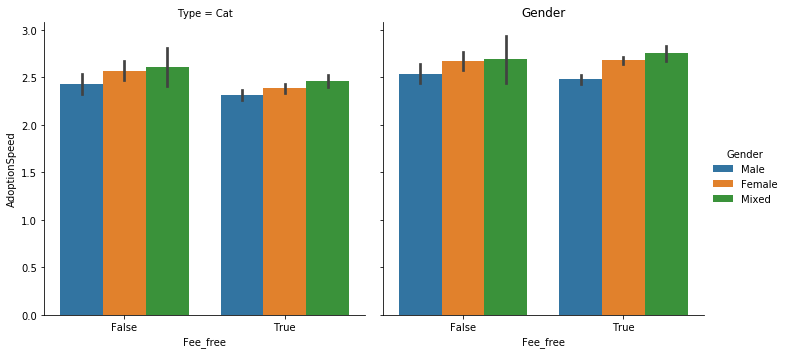

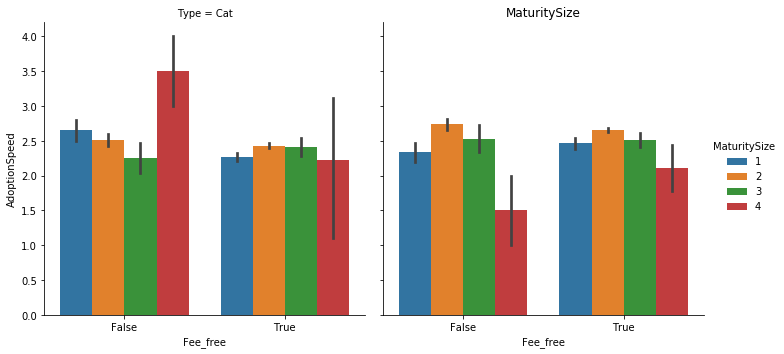

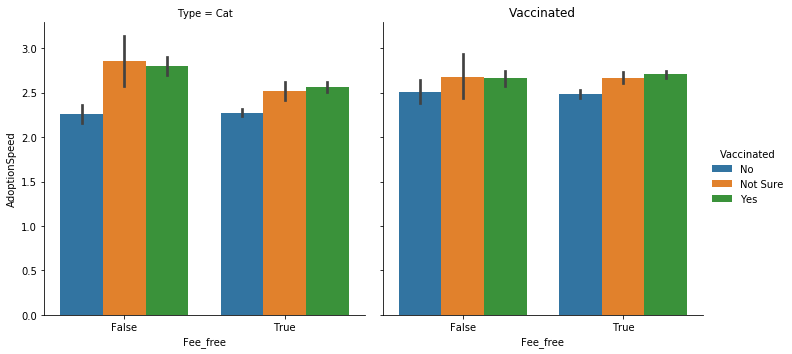

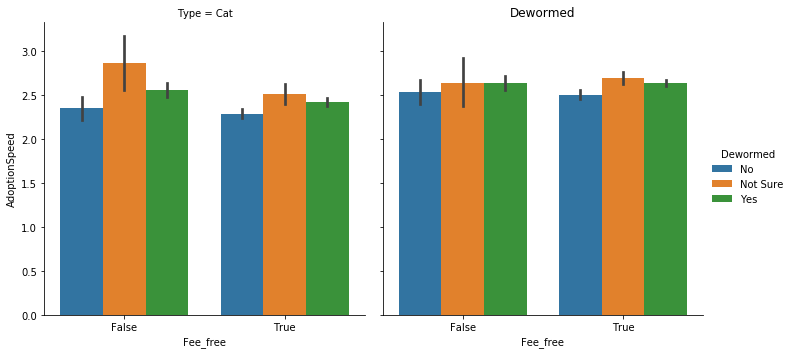

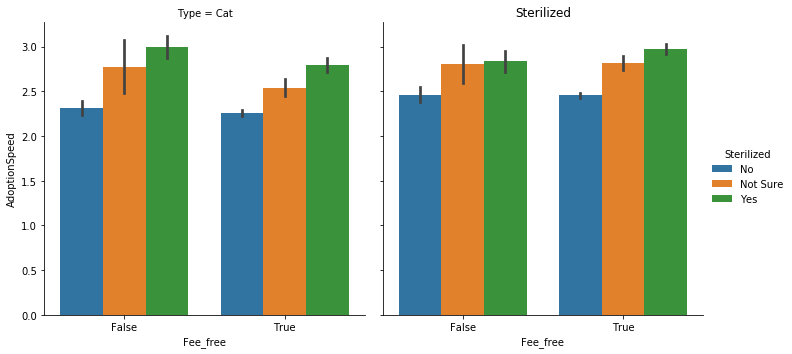

In [20]:
for col in ['Gender', 'MaturitySize', 'Vaccinated', 'Dewormed', 'Sterilized']:
    sns.catplot(x='Fee_free', y='AdoptionSpeed', kind='bar', hue=col, col='Type', data=df)
    plt.title(col);

- 다른 변수들은 큰 차이가 없지만, MaturitySize의 경우 유료/무료에 따라 큰 차이를 보임
    - Dog의 경우, 유료이면서 MaturitySize가 가장 큰 경우 입양이 빨리됨
    - Cat의 경우, 유료이면서 MaturitySize가 커질수록 빨리 입양되다가 가장 큰 4의 경우 입양이 오래 걸림

유/무료에 따라 Health, Maturity가 AdoptionSpeed에 영향을 미치는 것이 보이므로, 혹시 존재 할 수 있는 confounding factor들을 알아보기 위해 다변량 회귀분석을 할 필요성 있음.

### Health

시각화를 위해 ordinal한 변수는 명시적으로 매핑

In [21]:
df = df.replace({
    'MaturitySize': {1: 'Small', 2: 'Medium', 3: 'Large', 4: 'Extra Large', 0:'Not Specified'},
    'FurLength': {1:'Short', 2: 'Medium', 3: 'Long', 0: 'Not Specified'},
    'Health': {1: 'Healthy', 2: 'Minor Injury', 3: 'Serious Injury', 0: 'Not Specified'}
})

In [22]:
df.Health.value_counts(normalize=True)

Healthy           0.965651
Minor Injury      0.032082
Serious Injury    0.002268
Name: Health, dtype: float64

- 건강한 펫의 비율이 약 96%
- Injury가 있는 펫은 약 3%. 다친 펫은 애초에 입양 센터에 오지않을 확률이 크며 입양센터에서 받지 않는 경향이 있는 것으로 보임.

각 건강 상태별로 AdoptionSpeed가 어떻게 달라지는지 확인해보자.

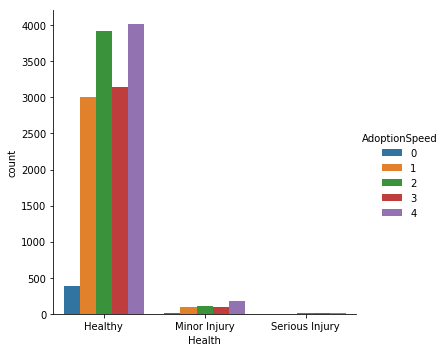

In [25]:
sns.catplot(x='Health', hue='AdoptionSpeed', kind="count", data=df)

- Healthy에 속한 케이스가 너무 많아서 다른 케이스들의 패턴을 보기가 어려움 
- 각 케이스 별로 시각화 할 필요 있음

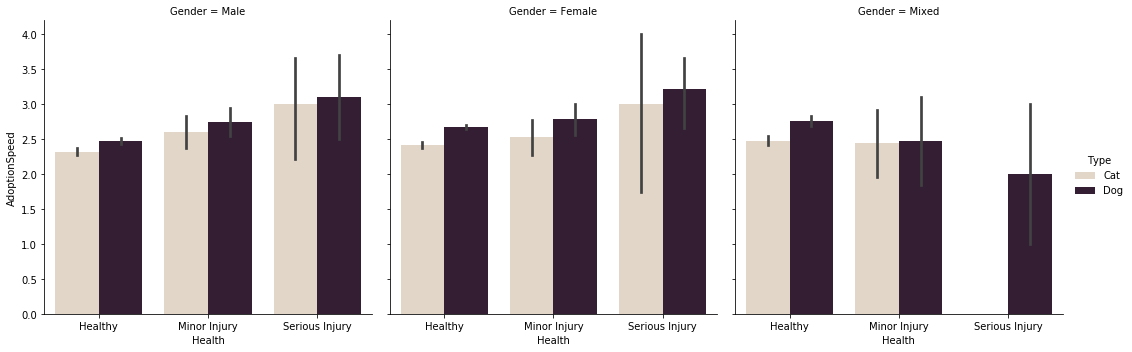

In [43]:
sns.catplot(x="Health", y="AdoptionSpeed", kind='bar', hue='Type', col='Gender', palette="ch:.25",data=df);

- 어쩌면 당연한 결과지만 펫의 부상 정도가 커짐에 따라서 급격히 입양 시간이 오래걸림
- 부상정도가 높아짐과 동시에 입양되는데 오래걸리고, 편차도 점점 커짐. 따라서 다른 요소들이 영향을 많이 미친다는 힌트를 얻을 수 있음
- Geneder = Mixed인 경우, 반대로 부상정도가 높아지면 입양이 빨리됨. 의외의 결과여서 좀 더 분석해볼 필요 있음

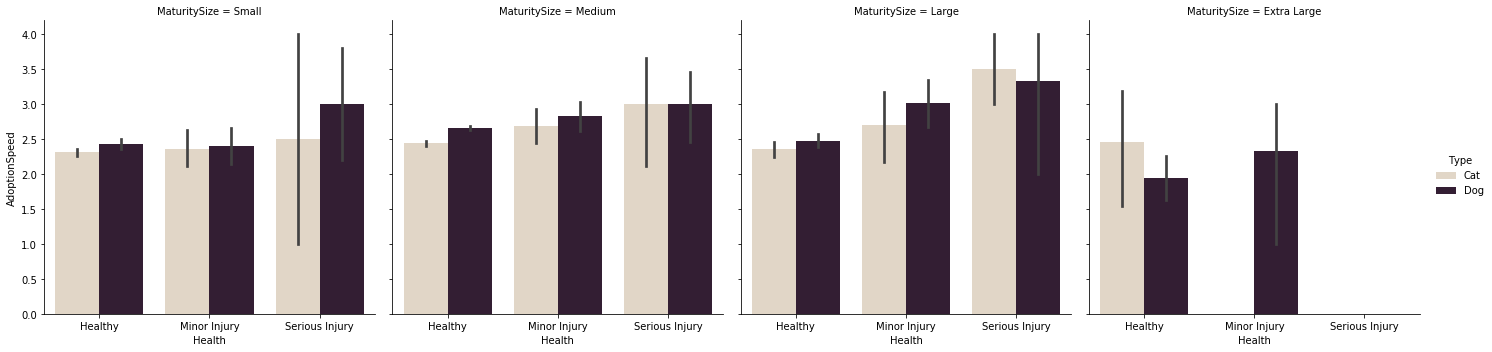

In [46]:
sns.catplot(x="Health", y="AdoptionSpeed", kind='bar', hue='Type', col='MaturitySize', palette="ch:.25",data=df);

### Type

#### 동물의 종류에 따라서 AdoptionSpeed의 차이가 있을까?

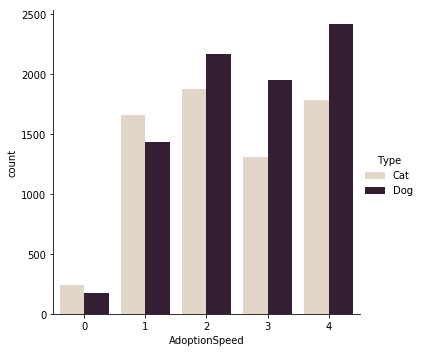

In [49]:
sns.catplot(x="AdoptionSpeed", hue='Type', kind="count", palette="ch:.25", data=df.loc[data.is_train]);

- 고양이가 강아지에 비해 더 빨리 입양됨
- Confounding factor가 존재할 수 있음. 예를 들면, 입양 센터에 들어온 고양이가 대체로 나이가 어리거나 더 건강할 수 있음.

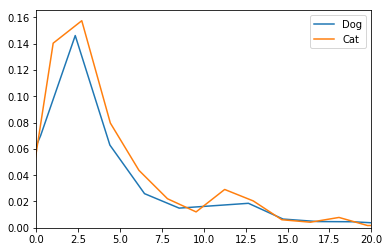

In [568]:
sns.kdeplot(df.loc[(df.is_train) & (df.Type == 'Dog'), 'Age'])
sns.kdeplot(df.loc[(df.is_train) & (df.Type == 'Cat'), 'Age'])
plt.xlim(0, 20)
plt.legend(['Dog', 'Cat']);

- 입양 센터의 강아지와 고양이 모두 나이는 비슷함

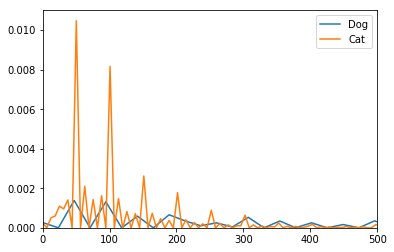

In [567]:
sns.kdeplot(df.loc[(df.is_train) & (df.Type == 'Dog'), 'Fee'])
sns.kdeplot(df.loc[(df.is_train) & (df.Type == 'Cat'), 'Fee'])
plt.xlim(0, 500)
plt.legend(['Dog', 'Cat']);

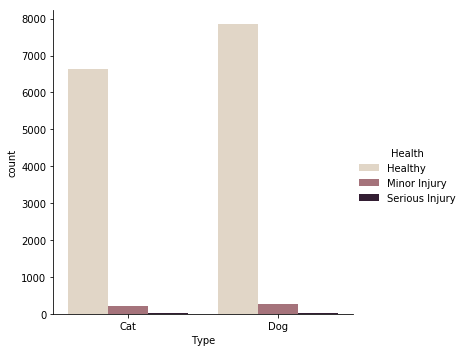

In [557]:
sns.catplot(x="Type", hue='Health', kind="count", palette="ch:.25", data=df.loc[data.is_train]);

In [564]:
df.loc[(df.is_train) & (df.Type=='Dog'), 'Health'].value_counts(normalize=True)

Healthy           0.964707
Minor Injury      0.032710
Serious Injury    0.002582
Name: Health, dtype: float64

In [565]:
df.loc[(df.is_train) & (df.Type=='Cat'), 'Health'].value_counts(normalize=True)

Healthy           0.966769
Minor Injury      0.031337
Serious Injury    0.001895
Name: Health, dtype: float64

- 비율상 입양 센터의 강아지와 고양이의 건강 상태는 큰 차이가 없음

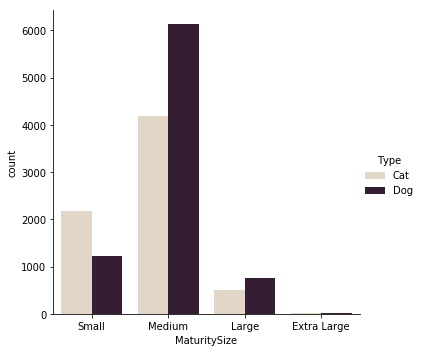

In [571]:
sns.catplot(x="MaturitySize", hue='Type', kind="count", palette="ch:.25", data=df.loc[data.is_train]);

- 반면, 사이즈가 작은 고양이가 사이즈가 작은 강아지보다 수가 더 많음.